# 5.¿Cómo  se  distribuyen  las  especies  fósiles  en las regiones de chile según  sus  hábitos alimenticios, y qué nos puede decir esto sobre la estructura ecológica de la región en diferentes períodos geológicos?

# Planteamiento del Problema
La distribución de especies fósiles en las regiones de Chile ofrece una ventana al pasado para entender cómo las interacciones ecológicas han evolucionado en el tiempo. Este análisis busca determinar cómo se distribuyen las especies según sus hábitos alimenticios y cómo estas distribuciones reflejan la estructura ecológica de las regiones en diferentes períodos geológicos.

### Objetivo General
Estudiar la distribución geográfica y temporal de las especies fósiles en Chile, centrándonos en sus hábitos alimenticios y su impacto en la estructura ecológica.

### Objetivos Específicos
1. Analizar los datos fósiles en términos de hábitos alimenticios y distribución geográfica.
2. Representar visualmente las distribuciones usando mapas y gráficos.
3. Identificar patrones ecológicos y geológicos relevantes.
4. Responder a la pregunta central con base en los datos y análisis realizados.


# 1. Importación y preparación de datos

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
import os
import seaborn as sns

In [2]:
#import zipfile
#
## Extraemos provincia.zip y Regiones.zip que están en la carpeta data
#with zipfile.ZipFile('data/Comunas_chile.zip', 'r') as zip_ref:
#    zip_ref.extractall('data/')
#

In [3]:
chile_df = pd.read_csv('data_clean/chile_clean.csv')
print("Columnas en el dataset principal:", chile_df.columns)

Columnas en el dataset principal: Index(['species_name', 'occurrence_no', 'accepted_name', 'phylum', 'class',
       'order', 'family', 'genus', 'lat', 'lng', 'diet', 'life_habit',
       'environment', 'taxon_environment', 'primary_name', 'era_early',
       'era_late'],
      dtype='object')


In [4]:
# Seleccionar columnas relevantes para el análisis
columns_to_use = ['diet', 'lat', 'lng', 'era_early', 'era_late']
df_diet = chile_df[columns_to_use]

In [5]:
df_diet = df_diet.copy()

# Filtrar valores nulos en coordenadas (latitud y longitud)
df_diet = df_diet[df_diet['lat'].notnull() & df_diet['lng'].notnull()]

# Crear geometrías a partir de las coordenadas
geometry = [Point(xy) for xy in zip(df_diet['lng'], df_diet['lat'])]
chile_geo_df = gpd.GeoDataFrame(df_diet, geometry=geometry, crs="EPSG:4326")

In [6]:
df_diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9481 entries, 0 to 9480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   diet       8749 non-null   object 
 1   lat        9481 non-null   float64
 2   lng        9481 non-null   float64
 3   era_early  9481 non-null   object 
 4   era_late   9481 non-null   object 
dtypes: float64(2), object(3)
memory usage: 370.5+ KB


No se eliminaran las filas que tienen valores nulos en las dietas, ya que se reducian como 700 lineas, las caules nos pueden ayudar en la distribucion de fosiles por era.

In [7]:
# Ver los valores únicos en la columna 'diet'.
unique_diets = df_diet['diet'].unique()
print(unique_diets)

# Ver también la cantidad de veces que aparece cada valor.
diet_counts = df_diet['diet'].value_counts()
print(diet_counts)

['deposit feeder, suspension feeder' 'deposit feeder' 'suspension feeder'
 'grazer' 'chemosymbiotic' 'chemosymbiotic, suspension feeder' 'omnivore'
 'carnivore' nan 'herbivore' 'microcarnivore, photosymbiotic'
 '"photoautotroph"' 'C3 autotroph' 'photosymbiotic, suspension feeder'
 'detritivore' 'insectivore' 'omnivore, grazer' 'grazer, carnivore'
 'piscivore, carnivore' 'piscivore' 'browser' 'grazer, browser'
 'carnivore, omnivore' 'frugivore, folivore'
 'carnivore, suspension feeder' 'deposit feeder, detritivore'
 'microcarnivore' 'grazer, deposit feeder'
 'detritivore, suspension feeder' 'carnivore, detritivore'
 'grazer, omnivore' 'durophage, carnivore' 'durophage, piscivore'
 'frugivore' 'herbivore, carnivore' 'suspension feeder, detritivore'
 'suspension feeder, carnivore' 'insectivore, carnivore' 'browser, grazer'
 'frugivore, granivore' 'insectivore, frugivore' 'granivore'
 'carnivore, parasite' 'browser, browser']
diet
suspension feeder                    4666
carnivore        

#### Normalización de las coordenadas geográficas: Sistema EPSG:4326 (latitud y longitud)

In [8]:
gdf_regiones = gpd.read_file(r'data/Regiones/Regional.shp').to_crs("EPSG:4326")
gdf_comunas = gpd.read_file(r'data/comunas/comunas.shp').to_crs("EPSG:4326")

# Hacer la unión espacial para agregar información de regiones al GeoDataFrame
chile_geo_df = gpd.sjoin(chile_geo_df, gdf_regiones, how='inner', predicate='within')

print("Primeras filas del GeoDataFrame procesado:")
print(chile_geo_df.head())

Primeras filas del GeoDataFrame procesado:
                                diet   lat   lng   era_early         era_late  \
0  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
1  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
2  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
3                     deposit feeder -37.0 -73.0  Cretaceous  No especificado   
4                     deposit feeder -37.0 -73.0  Cretaceous  No especificado   

          geometry  index_right  objectid  cir_sena  codregion       area_km  \
0  POINT (-73 -37)           12      1096        10          8  24021.621594   
1  POINT (-73 -37)           12      1096        10          8  24021.621594   
2  POINT (-73 -37)           12      1096        10          8  24021.621594   
3  POINT (-73 -37)           12      1096        10          8  24021.621594   
4  POINT (-73 -37)           12      1096        10          8  24021.

# 2. Limpieza y análisis descriptivo

### Lógica de Agrupación por dieta.
1. Filtros y Suspensores:
    -   Agrupa organismos que obtienen su alimento del agua o sedimentos mediante filtración o suspensión. Esto incluye aquellos que pueden tener características de alimentación tanto de depósitos como de suspensión.
2. Consumidores Primarios:
    -    Incluye organismos que se alimentan directamente de productores (plantas, algas) o fuentes primarias de alimento. Son generalmente herbívoros y se agrupan por su dieta de materia vegetal o frutas.
3. Consumidores Secundarios (Carnívoros):
    -    Comprende los organismos que se alimentan de otros animales. Esta categoría incluye varios tipos de carnívoros, desde depredadores generales hasta especializados (como piscívoros, que se alimentan de peces).
4. Omnívoros:
    -    Agrupa organismos que consumen tanto materia vegetal como animal. Esta categoría puede incluir aquellos que tienen dietas variadas y que no se limitan a un solo tipo de alimento.
5. Descomponedores y Detritívoros:
    -    Incluye organismos que se alimentan de materia orgánica en descomposición. Los detritívoros son esenciales para el reciclaje de nutrientes en los ecosistemas.
6. Simbiontes y Especializados:
    -    Agrupa organismos que tienen relaciones simbióticas o que dependen de procesos biológicos específicos para su alimentación, como los que obtienen energía a través de reacciones químicas (quimiosíntesis).
7. Otros Combinados:
    -    Incluye aquellos organismos que tienen dietas mixtas que no se ajustan claramente a las categorías anteriores. Estos pueden ser carnívoros que también consumen material vegetal o viceversa.

También los datos que no pertenezcan a ninguno de estos se considerarán como desconocidos.

In [9]:
filtros_y_suspensores = [
    'deposit feeder, suspension feeder',
    'suspension feeder',
    'photosymbiotic, suspension feeder',
    'detritivore, suspension feeder',
    'carnivore, suspension feeder'
]

consumidores_primarios = [
    'grazer',
    'herbivore',
    'frugivore',
    'granivore',
    'browser',
    'browser, grazer'
]

consumidores_secundarios = [
    'carnivore',
    'microcarnivore',
    'piscivore',
    'insectivore',
    'durophage, carnivore',
    'insectivore, carnivore',
    'carnivore, omnivore',
    'carnivore, parasite'
]

omnivoros = [
    'omnivore',
    'omnivore, grazer',
    'herbivore, carnivore',
    'frugivore, folivore',
    'grazer, omnivore'
]

descomponedores_y_detritivoros = [
    'detritivore',
    'deposit feeder, detritivore',
    'grazer, deposit feeder',
    'detritivore, suspension feeder'
]

simbiontes_y_especializados = [
    'chemosymbiotic',
    'chemosymbiotic, suspension feeder',
    'microcarnivore, photosymbiotic',
    '"photoautotroph"',
    'C3 autotroph'
]

otros_combinados = [
    'grazer, carnivore',
    'piscivore, carnivore',
    'durophage, piscivore',
    'insectivore, frugivore'
]

In [10]:
def categorize_diet(diet):
    if pd.isna(diet):
        return 'incertidumbre'

    if not isinstance(diet, str):
        return 'incertidumbre'
    
    diet = diet.lower()

    if diet in filtros_y_suspensores:
        return 'filtros y suspensores'
    elif diet in consumidores_primarios:
        return 'consumidores primarios'
    elif diet in consumidores_secundarios:
        return 'consumidores secundarios'
    elif diet in omnivoros:
        return 'omnivoros'
    elif diet in descomponedores_y_detritivoros:
        return 'descomponedores y detritívoros'
    elif diet in simbiontes_y_especializados:
        return 'simbiontes y especializados'
    elif diet in otros_combinados:
        return 'otros combinados'
    
    # Si no se encuentra en ninguna categoría, devolver 'incertidumbre'
    return 'incertidumbre'

In [11]:
# Aplicar la categorización al DataFrame
chile_geo_df['diet_grouped'] = chile_geo_df['diet'].apply(categorize_diet)
# Verificar las agrupaciones
print("Conteo por grupos de dieta:")
print(chile_geo_df['diet_grouped'].value_counts())


Conteo por grupos de dieta:
diet_grouped
filtros y suspensores             4718
consumidores secundarios          2183
incertidumbre                      855
consumidores primarios             502
simbiontes y especializados        323
omnivoros                          319
descomponedores y detritívoros      50
otros combinados                    33
Name: count, dtype: int64


# 3. Visualización geográfica

### Mapeo por dieta en Chile:

In [12]:
def mapear_dietas(df_diet, gdf_comunas, columna_dieta='diet_grouped', titulo="Distribución de Dietas en Chile"):
    df_diet = df_diet[df_diet['lat'].notnull() & df_diet['lng'].notnull()]
    geometry = [Point(xy) for xy in zip(df_diet['lng'], df_diet['lat'])]
    
    chile_geo_df = gpd.GeoDataFrame(df_diet, geometry=geometry, crs="EPSG:4326")
    colores = {
        'filtros y suspensores': 'blue',
        'consumidores primarios': 'green',
        'consumidores secundarios': 'red',
        'omnivoros': 'orange',
        'descomponedores y detritívoros': 'purple',
        'simbiontes y especializados': 'cyan',
        'otros combinados': 'magenta'
    }

    if colores is None:
        categorias = chile_geo_df[columna_dieta].unique()
        colores = {cat: plt.cm.get_cmap('tab20')(i / len(categorias)) for i, cat in enumerate(categorias)}
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    gdf_comunas.plot(ax=ax, color='lightgrey', edgecolor='black')  # Fondo de las comunas

    for dieta, color in colores.items():
        subset = chile_geo_df[chile_geo_df[columna_dieta] == dieta]
        if not subset.empty:  # Evitar errores con conjuntos vacíos
            subset.plot(ax=ax, color=color, markersize=10, label=dieta, alpha=0.6)
    
    ax.set_aspect('equal')
    plt.legend(title=columna_dieta, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(titulo, fontsize=16)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()


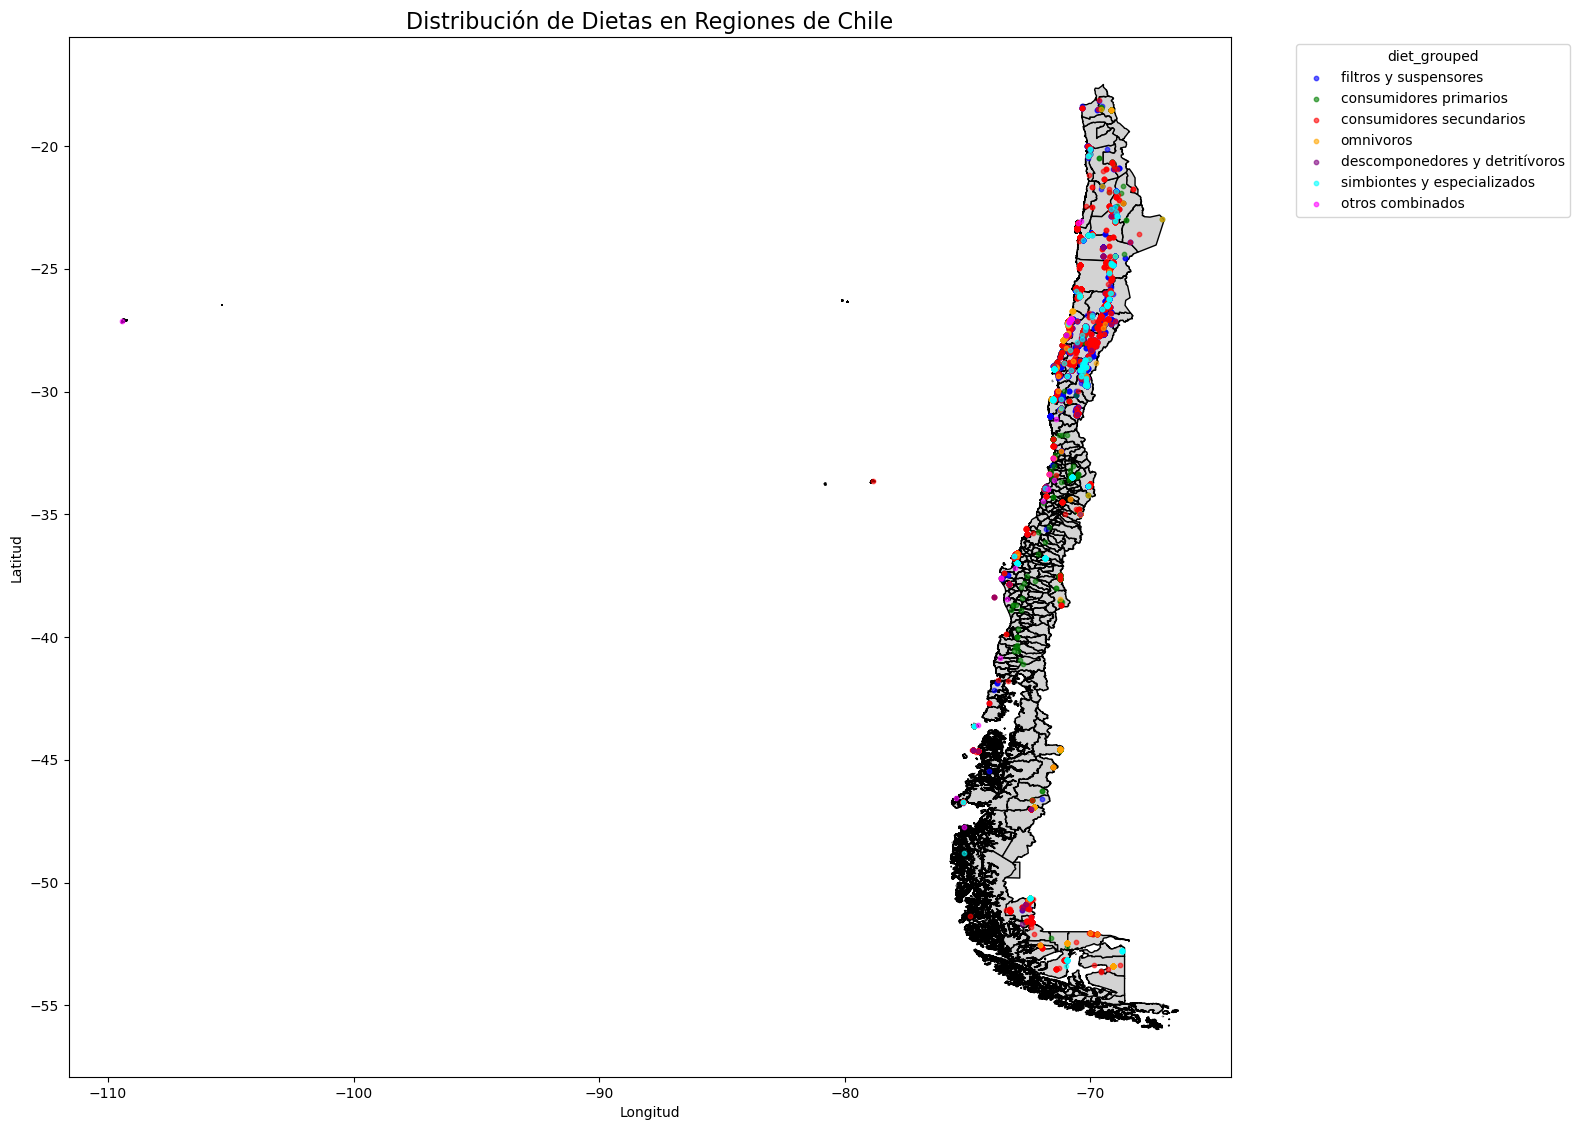

In [13]:
mapear_dietas(chile_geo_df, gdf_comunas,'diet_grouped',"Distribución de Dietas en Regiones de Chile")

## Análisis inicial
Las regiones costeras parecen contener una mayor diversidad de dietas fósiles, posiblemente relacionadas con ambientes marinos y terrestres.

En el sur de Chile, hay un predominio de consumidores secundarios y omnívoros, lo que podría indicar ecosistemas complejos en el pasado

Densidad por grupo:

Filtros y suspensores (azul): Alta densidad en la costa, lo que podría estar relacionado con fósiles de organismos marinos como moluscos o corales.
Consumidores primarios y secundarios (verde y rojo): Distribuidos de manera más uniforme, lo que sugiere la presencia de especies herbívoras y carnívoras en diversos ambientes.
Omnívoros (naranga): Más dispersos, pero presentes en áreas clave.

Zonas vacías:

Algunas regiones del norte parecen no tener fósiles identificados, lo cual podría deberse a:
Falta de exploración paleontológica.
Regiones con condiciones desfavorables para la conservación de fósiles.

Factores geológicos y climáticos:

Las regiones con mayor diversidad pueden estar relacionadas con depósitos sedimentarios ricos o condiciones climáticas históricas favorables para la vida.

Evolución temporal:

La concentración en áreas específicas podría reflejar la evolución geológica y climática de Chile, destacando eventos como cambios en el nivel del mar o la formación de cordilleras.

### Mapear por regiones especificas de Chile:

Análisis específico para la región más abundante.

In [14]:
def plot_regions_and_communes(region_names, gdf_regiones, gdf_comunas, chile_geo_df):
    regions_shape = gdf_regiones[gdf_regiones['Region'].isin(region_names)]
    comunas_shape = gdf_comunas[gdf_comunas['Region'].isin(region_names)]
    regions_fossils = chile_geo_df[chile_geo_df['Region'].isin(region_names)]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    regions_shape.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
    comunas_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    
    colors = {
        'filtros y suspensores': 'blue',
        'consumidores primarios': 'green',
        'consumidores secundarios': 'red',
        'omnivoros': 'orange',
        'descomponedores y detritívoros': 'purple',
        'simbiontes y especializados': 'cyan',
        'otros combinados': 'magenta',
    }
    
    for diet, color in colors.items():
        subset = regions_fossils[regions_fossils['diet_grouped'] == diet]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=10, label=diet, alpha=0.6)
    
    plt.legend()
    plt.title(f"Fósiles por habito alimenticio en la Región {region_names}", fontsize=14)
    plt.show()


In [15]:
#plot_regions_and_communes(['Región de Antofagasta'], gdf_regiones, gdf_comunas, chile_geo_df)

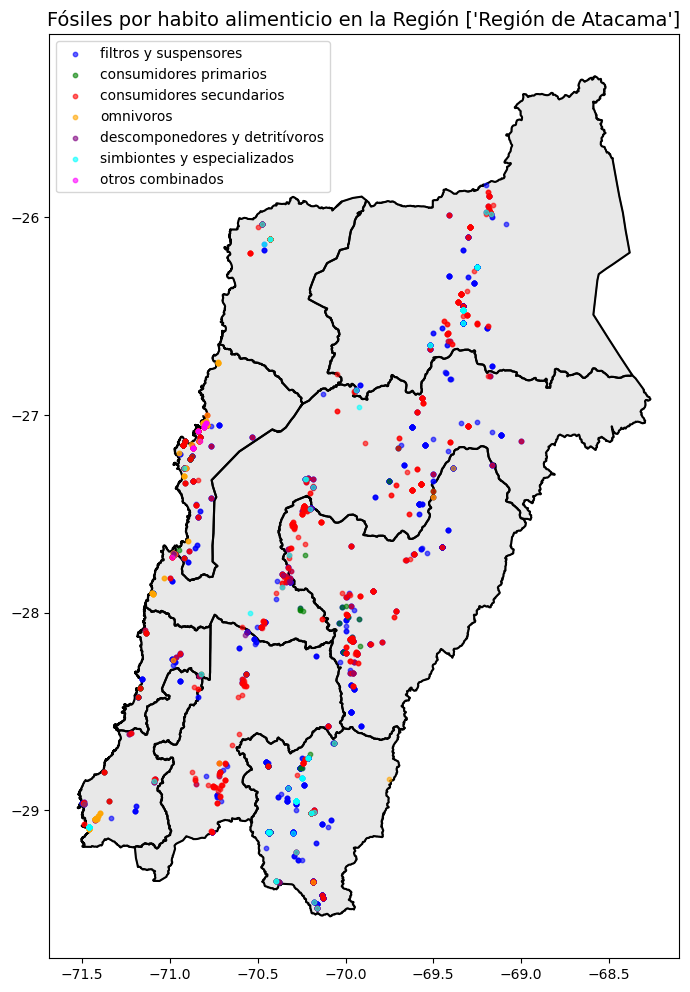

In [16]:

plot_regions_and_communes(['Región de Atacama'], gdf_regiones, gdf_comunas, chile_geo_df)

Zonas de concentración:

En las áreas costeras (al oeste), la densidad de fósiles es notablemente mayor, posiblemente reflejando una mayor preservación en depósitos marinos.

Relación con el entorno actual:

Las áreas con mayor diversidad fósil podrían coincidir con depósitos sedimentarios clave o zonas de interés paleontológico.

Ecología regional:

La región de Atacama, con su diversidad climática y geológica, parece haber albergado diferentes ecosistemas, desde marinos hasta terrestres.

La coexistencia de grupos como consumidores secundarios, omnívoros y simbiontes sugiere un ecosistema funcional con interacciones tróficas complejas.

### Fósiles agrupados por dieta

In [17]:
def plot_diet_distribution(df, title="Distribución de Dietas"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='diet_grouped', order=df['diet_grouped'].value_counts().index, palette="viridis")
    plt.title(title)
    plt.xlabel("Cantidad de Fósiles")
    plt.ylabel("Grupo de Dietas")
    plt.show()

C:\Users\FZ6\AppData\Local\Temp\ipykernel_9836\2026075114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='diet_grouped', order=df['diet_grouped'].value_counts().index, palette="viridis")


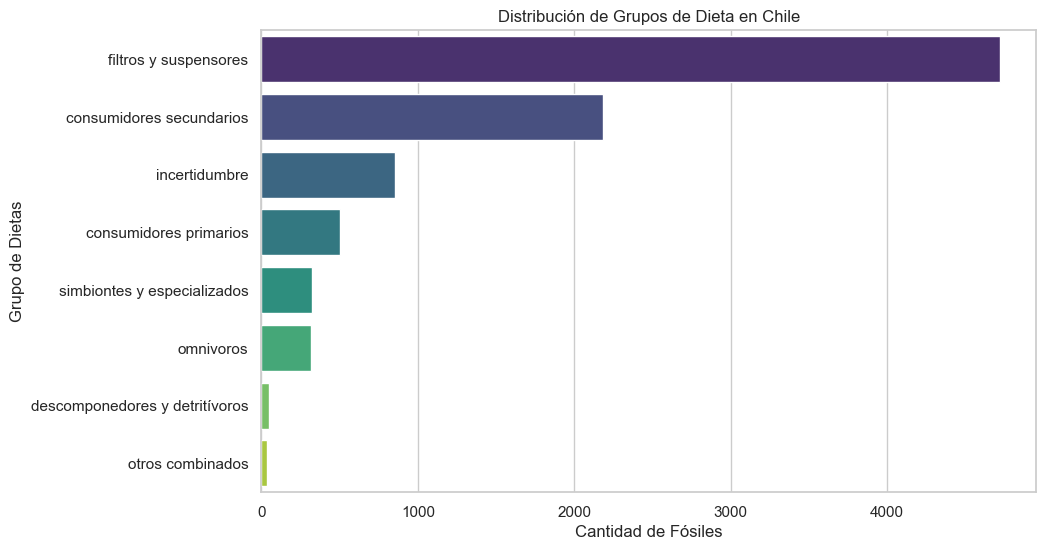

In [18]:
plot_diet_distribution(chile_geo_df, "Distribución de Grupos de Dieta en Chile")

El grupo de dieta más abundante en Chile son los "filtros y suspensores", con una cantidad de fósiles superior a 4,500, lo que indica su alta representatividad en el registro fósil.

El segundo grupo más numeroso corresponde a los "consumidores secundarios", que también muestran una significativa presencia en los registros.

Notamos que en los datos tenemos aproximadamente 900 fosiles que no se sabe a que grupo de dieta corresponde.

Por otro lado, los "consumidores primarios" y los "simbiontes y especializados" tienen una representación intermedia, lo que sugiere una participación moderada en los ecosistemas fósiles registrados.

Los grupos menos abundantes incluyen a los "omnívoros", el grupo clasificado como "desconocido", los "descomponedores y detritívoros", y los "otros combinados", que presentan una menor cantidad de fósiles.

La diversidad de grupos de dieta representados en el gráfico evidencia que el registro fósil de Chile abarca una amplia gama de nichos ecológicos y estrategias alimenticias, lo que refleja la complejidad de los ecosistemas que existieron en la región.

Finalmente, la predominancia de los "filtros y suspensores" indica que este grupo de organismos fue particularmente exitoso en los ecosistemas de su época, dejando un registro fósil considerablemente mayor en comparación con otros grupos tróficos.

### Mapear por era

In [19]:

def plot_fossils_by_era(region_name, gdf_regiones, gdf_comunas, chile_geo_df, top_n=5):
    region_shape = gdf_regiones[gdf_regiones['Region'] == region_name]
    if region_shape.empty:
        print(f"La región '{region_name}' no existe en el shapefile.")
        return
    
    region_fossils = chile_geo_df[chile_geo_df['Region'] == region_name]
    top_eras = region_fossils.groupby('era_early')['diet'].nunique().nlargest(top_n)
    print(f"Top {top_n} épocas con más especies únicas en la región {region_name}:")
    print(top_eras)
    
    filtered_fossils = region_fossils[region_fossils['era_early'].isin(top_eras.index)]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    region_shape.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
    
    comunas_shape = gdf_comunas[gdf_comunas['Region'] == region_name]
    comunas_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    fixed_colors = {
        'Cretaceous': 'orange',
        'Neogene': 'green',
        'Paleogene': 'blue',
        'Jurassic': 'red',
        'Triassic': 'purple',
        'Permian': 'cyan',
        'Carboniferous': 'magenta',

    }

    for era in top_eras.index:
        subset = filtered_fossils[filtered_fossils['era_early'] == era]
        if era in fixed_colors:
            color = fixed_colors[era]
        else:
            color = 'black'
        subset.plot(ax=ax, color=color, markersize=12, label=era, alpha=0.8)
    
    plt.legend(title="Época", loc='upper right')
    plt.title(f"Fósiles por Época en la Región {region_name}", fontsize=14)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()

def plot_fossils_by_era_in_zones(zones, gdf_regiones, gdf_comunas, chile_geo_df, top_n=5):
    for zone in zones:
        for region in zone:
            print(f"Graficando para la región: {region}")
            plot_fossils_by_era(region, gdf_regiones, gdf_comunas, chile_geo_df, top_n)

In [20]:
norte = [
    'Región de Arica y Parinacota',
    'Región de Tarapacá',
    'Región de Antofagasta',
    'Región de Atacama',
    'Región de Coquimbo'
]

centro = [
    'Región de Valparaíso',
    'Región Metropolitana de Santiago',
    "Región del Libertador Bernardo O'Higgins",
    'Región del Maule',
    'Región de Ñuble',
    'Región del Bío-Bío'
]

sur = [
    'Región de La Araucanía',
    'Región de Los Ríos',
    'Región de Los Lagos',
    'Región de Aysén del Gral. Ibañez del Campo',
    'Región de Magallanes y Antártica Chilena'
]

Graficando para la región: Región de Arica y Parinacota
Top 5 épocas con más especies únicas en la región Región de Arica y Parinacota:
era_early
Neogene       3
Jurassic      2
Quaternary    2
Cretaceous    1
Name: diet, dtype: int64


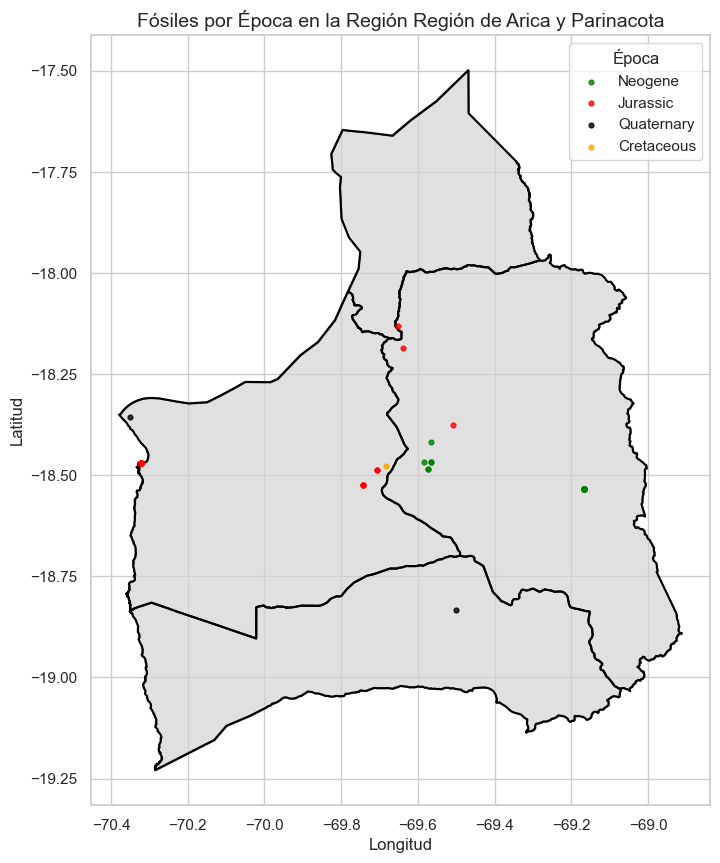

Graficando para la región: Región de Tarapacá
Top 5 épocas con más especies únicas en la región Región de Tarapacá:
era_early
Jurassic       7
Quaternary     3
Cretaceous     2
Phanerozoic    2
Permian        1
Name: diet, dtype: int64


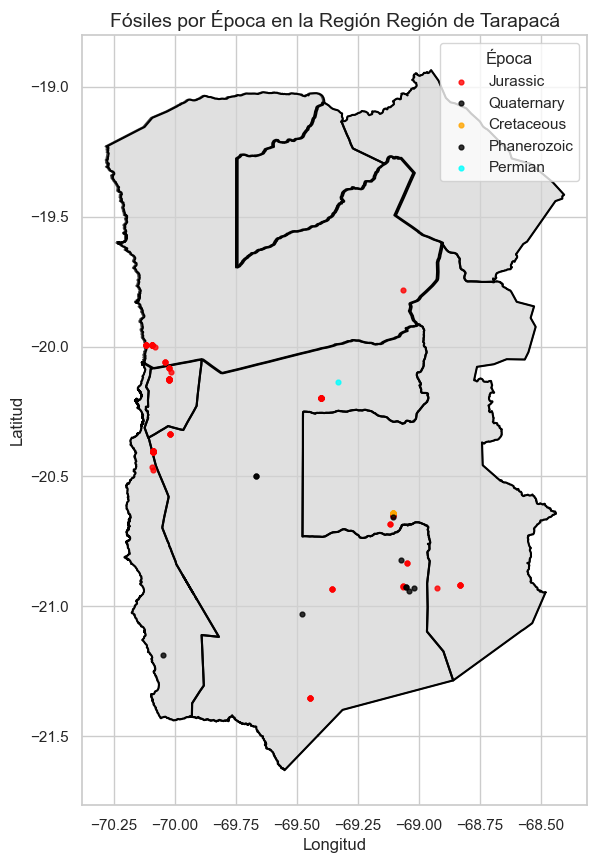

Graficando para la región: Región de Antofagasta
Top 5 épocas con más especies únicas en la región Región de Antofagasta:
era_early
Jurassic      12
Quaternary     9
Cretaceous     8
Triassic       8
Neogene        6
Name: diet, dtype: int64


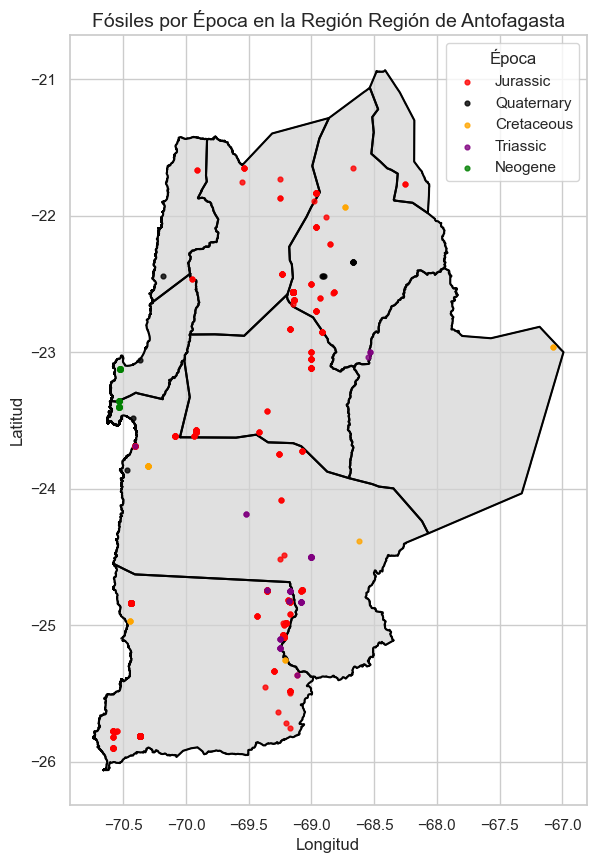

Graficando para la región: Región de Atacama
Top 5 épocas con más especies únicas en la región Región de Atacama:
era_early
Jurassic      16
Neogene       14
Cretaceous    13
Triassic       6
Quaternary     5
Name: diet, dtype: int64


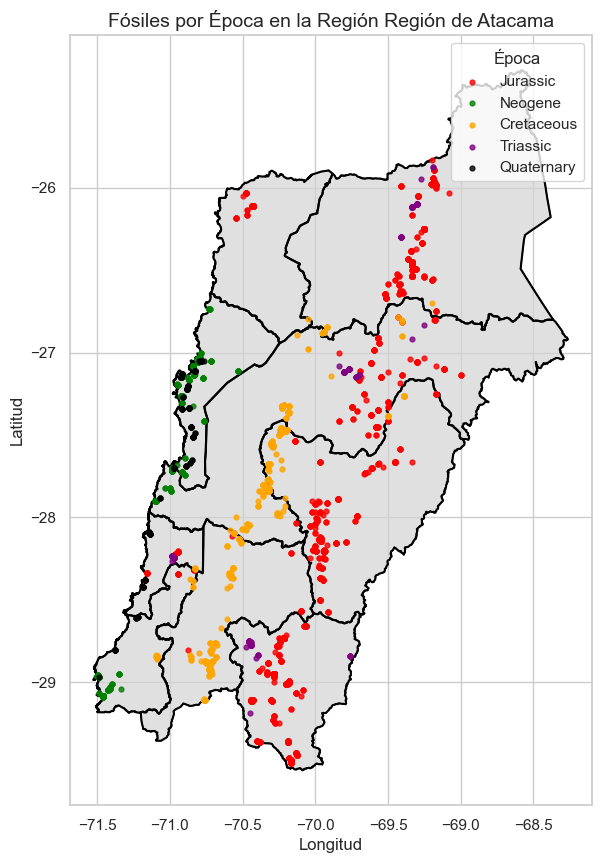

Graficando para la región: Región de Coquimbo
Top 5 épocas con más especies únicas en la región Región de Coquimbo:
era_early
Cretaceous       12
Jurassic         11
Quaternary       10
Neogene           8
Carboniferous     1
Name: diet, dtype: int64


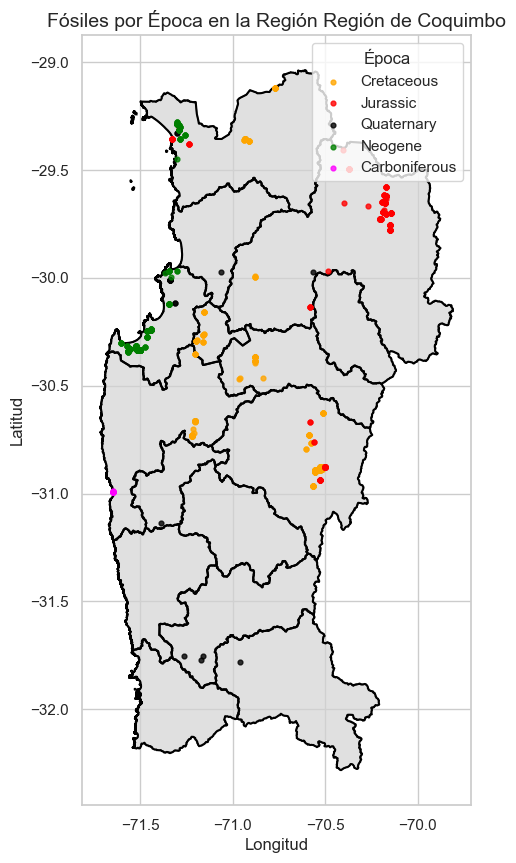

Graficando para la región: Región de Valparaíso
Top 5 épocas con más especies únicas en la región Región de Valparaíso:
era_early
Neogene       7
Quaternary    4
Cretaceous    3
Jurassic      3
Triassic      2
Name: diet, dtype: int64


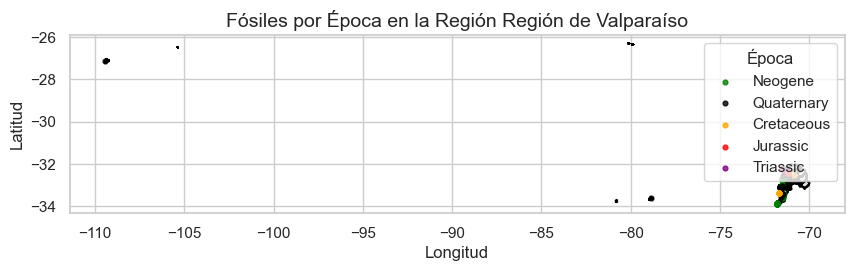

Graficando para la región: Región Metropolitana de Santiago
Top 5 épocas con más especies únicas en la región Región Metropolitana de Santiago:
era_early
Jurassic      8
Neogene       5
Cretaceous    4
Quaternary    3
Name: diet, dtype: int64


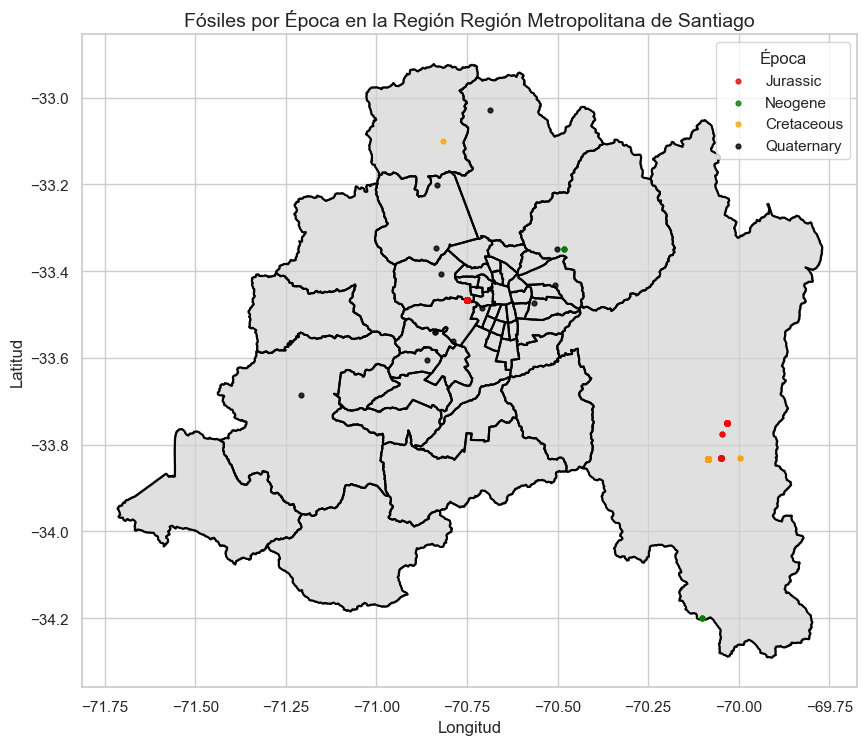

Graficando para la región: Región del Libertador Bernardo O'Higgins
Top 5 épocas con más especies únicas en la región Región del Libertador Bernardo O'Higgins:
era_early
Neogene       14
Quaternary    10
Paleogene      4
Jurassic       2
Name: diet, dtype: int64


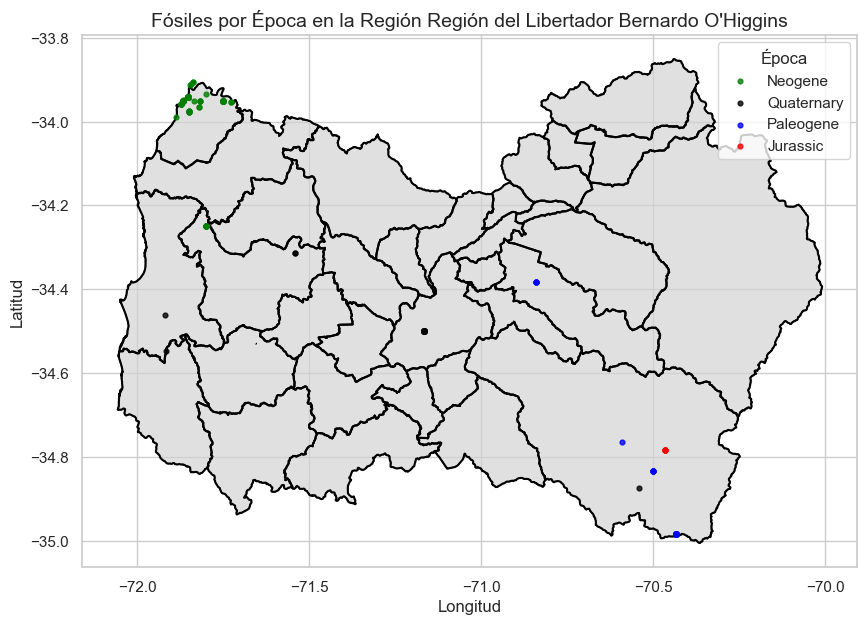

Graficando para la región: Región del Maule
Top 5 épocas con más especies únicas en la región Región del Maule:
era_early
Quaternary    3
Cretaceous    2
Jurassic      2
Neogene       1
Paleogene     1
Name: diet, dtype: int64


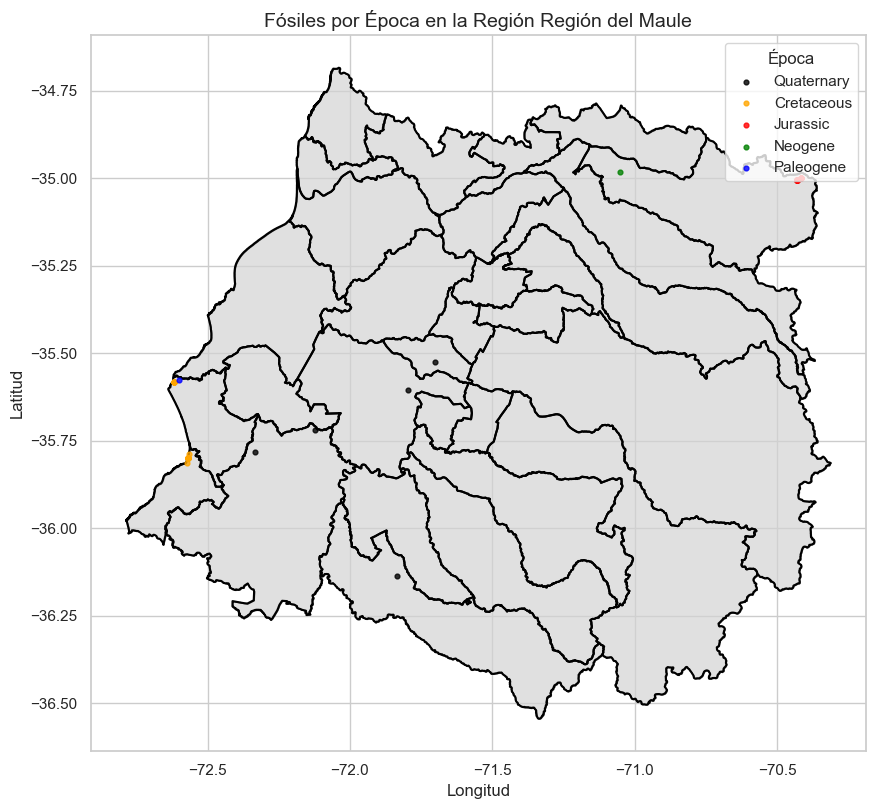

Graficando para la región: Región de Ñuble
Top 5 épocas con más especies únicas en la región Región de Ñuble:
era_early
Paleogene     1
Quaternary    1
Name: diet, dtype: int64


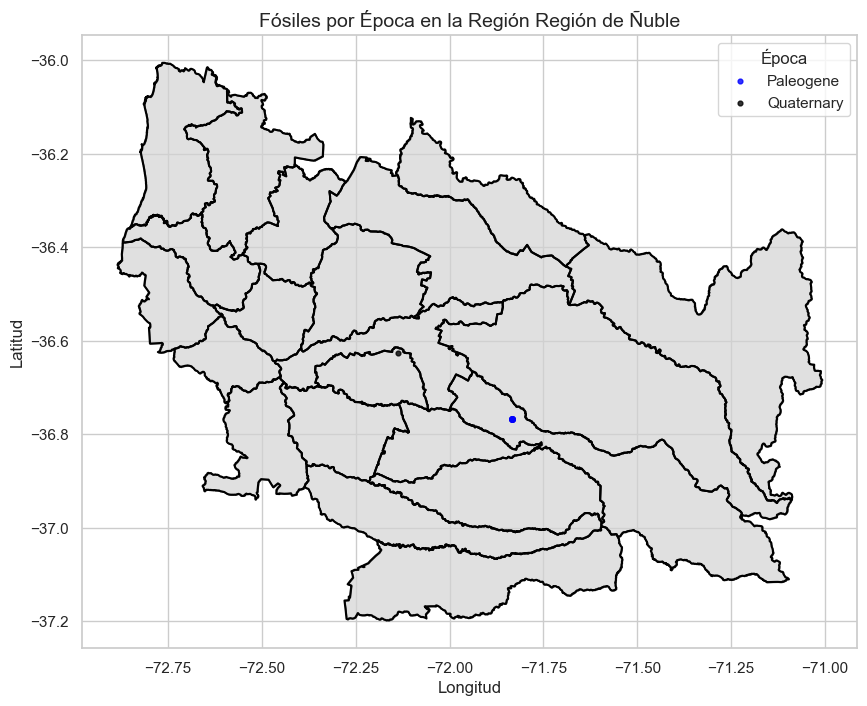

Graficando para la región: Región del Bío-Bío
Top 5 épocas con más especies únicas en la región Región del Bío-Bío:
era_early
Neogene       12
Cretaceous     9
Quaternary     7
Triassic       2
Paleogene      0
Name: diet, dtype: int64


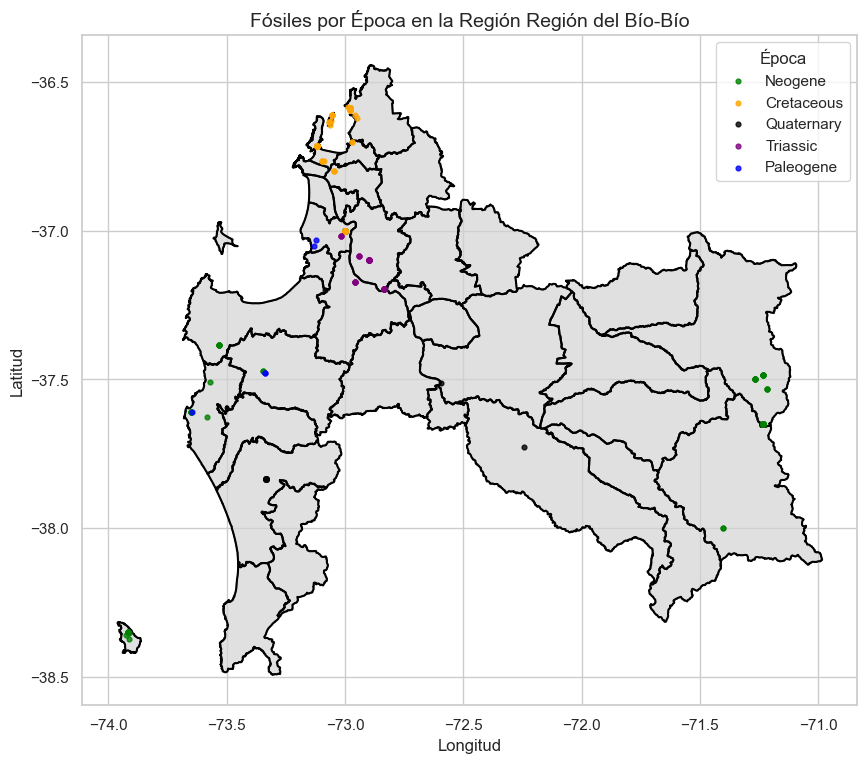

Graficando para la región: Región de La Araucanía
Top 5 épocas con más especies únicas en la región Región de La Araucanía:
era_early
Neogene       4
Quaternary    2
Name: diet, dtype: int64


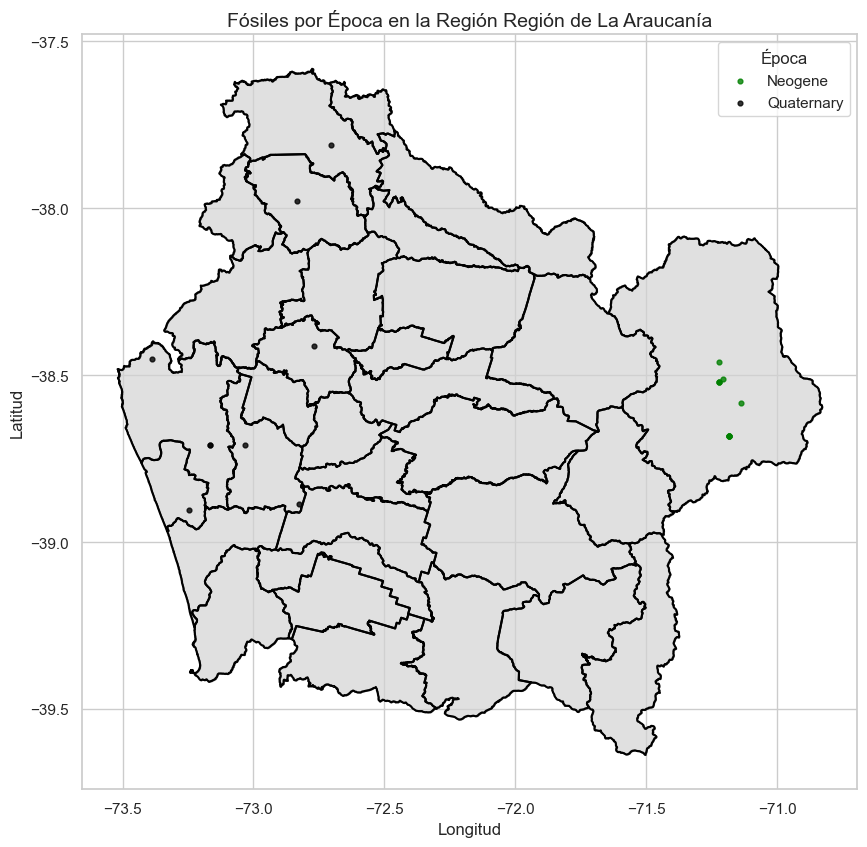

Graficando para la región: Región de Los Ríos
Top 5 épocas con más especies únicas en la región Región de Los Ríos:
era_early
Quaternary    3
Neogene       1
Triassic      0
Name: diet, dtype: int64


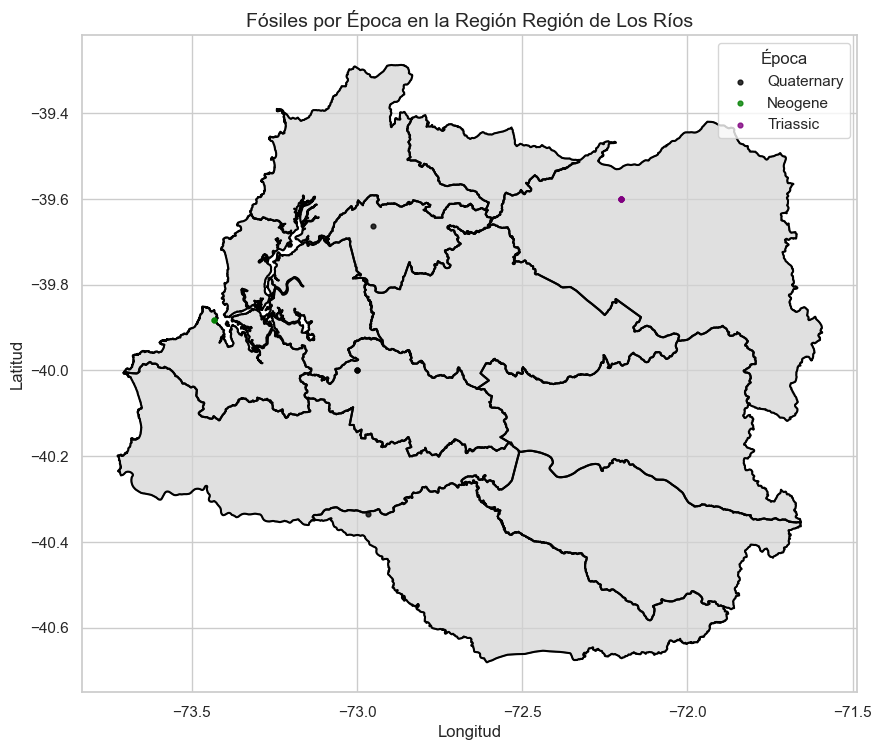

Graficando para la región: Región de Los Lagos
Top 5 épocas con más especies únicas en la región Región de Los Lagos:
era_early
Neogene       7
Quaternary    4
Paleogene     1
Name: diet, dtype: int64


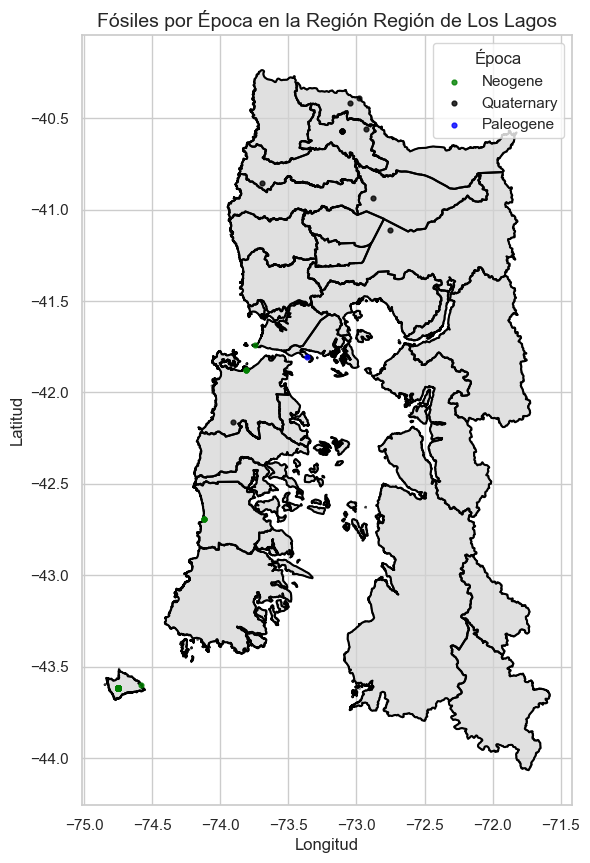

Graficando para la región: Región de Aysén del Gral. Ibañez del Campo
La región 'Región de Aysén del Gral. Ibañez del Campo' no existe en el shapefile.
Graficando para la región: Región de Magallanes y Antártica Chilena
Top 5 épocas con más especies únicas en la región Región de Magallanes y Antártica Chilena:
era_early
Cretaceous    11
Quaternary     8
Neogene        6
Paleogene      6
Jurassic       2
Name: diet, dtype: int64


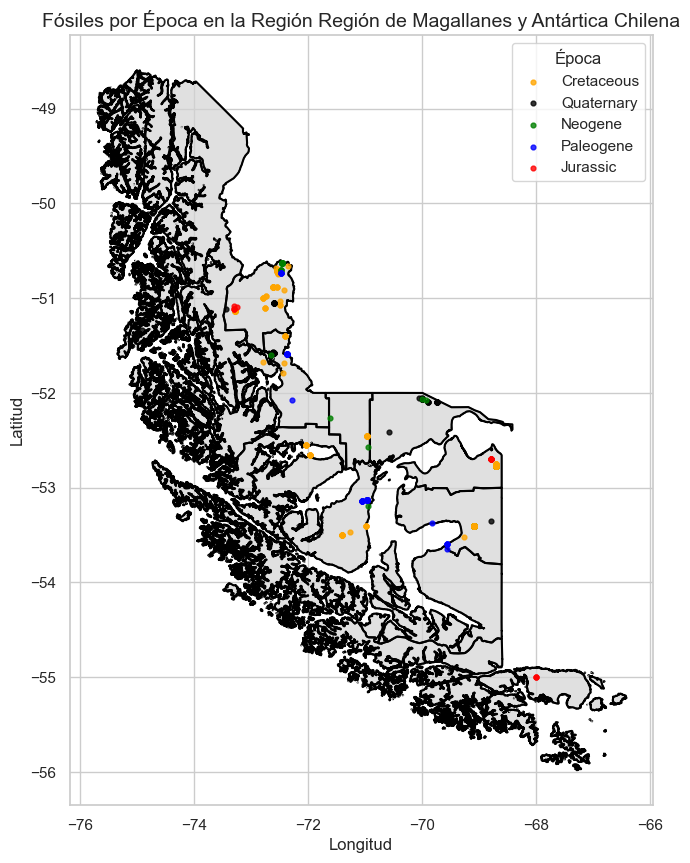

In [21]:
# Llamar a la función para graficar fósiles por era en las zonas Norte, Centro y Sur (mostrara cada region!)
plot_fossils_by_era_in_zones([norte, centro, sur], gdf_regiones, gdf_comunas, chile_geo_df, top_n=5)

Enfocandonos solo en Atacama ya que es la region mas abundante.

Distribución geológica:

Las líneas rectas podrían reflejar la disposición de afloramientos geológicos expuestos en la región. Estas formaciones suelen tener patrones lineales debido a procesos tectónicos, sedimentarios o de erosión que exponen las capas de roca de ciertas eras en franjas definidas.

Esfuerzo de muestreo:
Es posible que los paleontólogos hayan realizado muestreos a lo largo de rutas específicas o áreas accesibles (como carreteras o ríos), lo que podría resultar en patrones lineales en los datos recolectados.


Durante el Jurásico y el Cretácico, gran parte de lo que hoy es Atacama estuvo cubierta por mares someros, lo que explica la abundancia de fósiles marinos.

La presencia de fósiles del Triásico, puede asociarse con ambientes más continentales o fluviales en zonas donde existían sistemas de ríos y lagos.
La gran cantidad de fósiles del Neógeno (verde) en lo largo de chile puede deberse a eventos volcánicos o tectónicos que generaron condiciones favorables para la fosilización en ese período.

### Fósiles agrupados por era

In [22]:
# Función para graficar fósiles agrupados por era
def plot_era_distribution(df, title="Distribución de Fósiles por Era"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='era_early', kde=False, bins=20, color='skyblue')
    plt.title(title)
    plt.xlabel("Era (Millones de Años)")
    plt.ylabel("Cantidad de Fósiles")
    plt.xticks(rotation=45)
    plt.show()

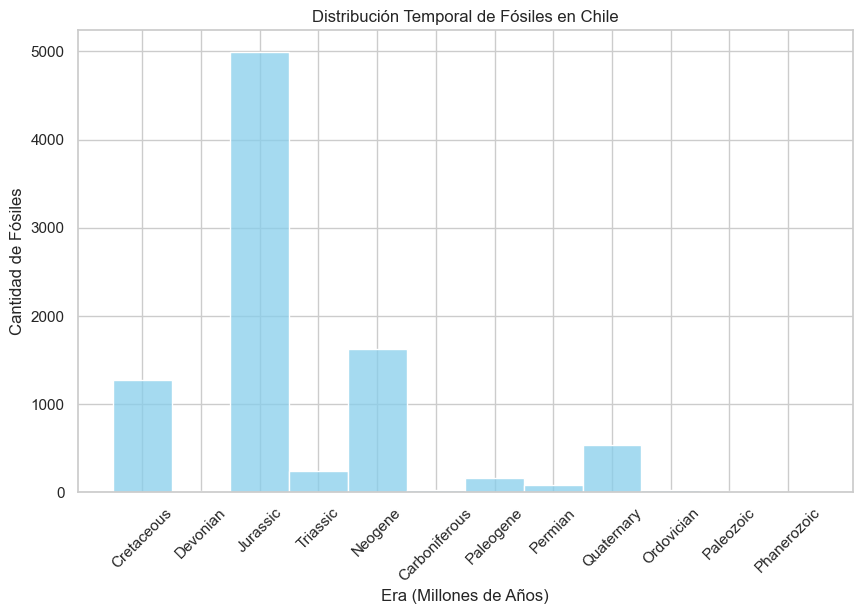

In [23]:
plot_era_distribution(chile_geo_df, "Distribución Temporal de Fósiles en Chile")

La era con mayor cantidad de fósiles registrados es el Jurásico, con aproximadamente 5.000 fósiles, lo que sugiere que fue una de las eras con mayor biodiversidad o mejores condiciones para la preservación fósil.

Otras eras con una notable presencia de fósiles son el Cretácico, el Neógeno y el Cuaternario, que también muestran una rica diversidad de organismos preservados.

Por otro lado, eras como el Paleógeno, el Pérmico, entre otros, presentan una menor cantidad de fósiles, lo que podría indicar períodos de menor actividad biológica, condiciones menos favorables para la fosilización o lagunas en el registro fósil debido a factores geológicos o de muestreo.

# 4. Clustering K-means

## Clustering para la distribución geográfica de los fósiles

Aquí usamos las coordenadas geográficas (lat, lng) para identificar patrones de distribución espacial. Este tipo de clustering permite observar:

Áreas donde los fósiles están más concentrados.

Diferenciación entre regiones basadas en las ubicaciones de los fósile

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

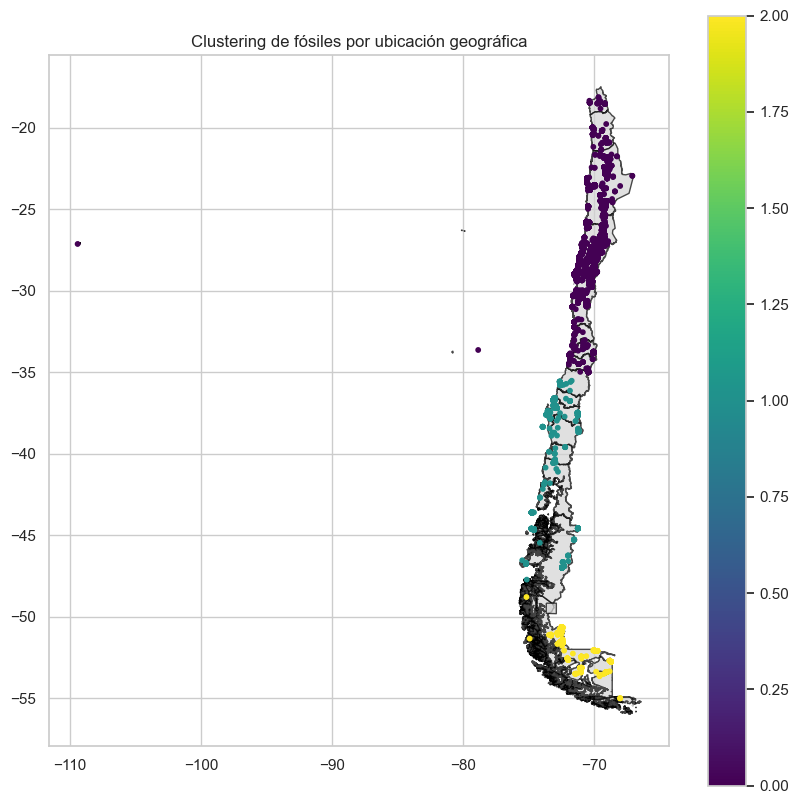

In [25]:
coordinates = chile_geo_df[['lat', 'lng']]

kmeans = KMeans(n_clusters=3)  # Número de clústeres óptimo según el método del codo.
chile_geo_df['cluster'] = kmeans.fit_predict(coordinates)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_regiones.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
chile_geo_df.plot(ax=ax, column='cluster', cmap='viridis', markersize=10, legend=True)
plt.title("Clustering de fósiles por ubicación geográfica")
plt.show()

El mapa muestra una concentración de fósiles en la zona centro-sur de Chile, con algunos grupos más aislados en el norte y sur del país. Se puede apreciar que los fósiles se organizan en tres grandes clústeres geográficos, lo que sugiere que existen patrones de distribución y agrupamiento de los yacimientos paleontológicos a lo largo del territorio chileno (concordando con el territorio separado por zona norte, centro y sur).

### Clustering por dieta

Por grupos actuales:

    lat   lng  diet_encoded  diet_cluster
0 -37.0 -73.0             3             2
1 -37.0 -73.0             3             2
2 -37.0 -73.0             3             2
3 -37.0 -73.0             4             2
4 -37.0 -73.0             4             2


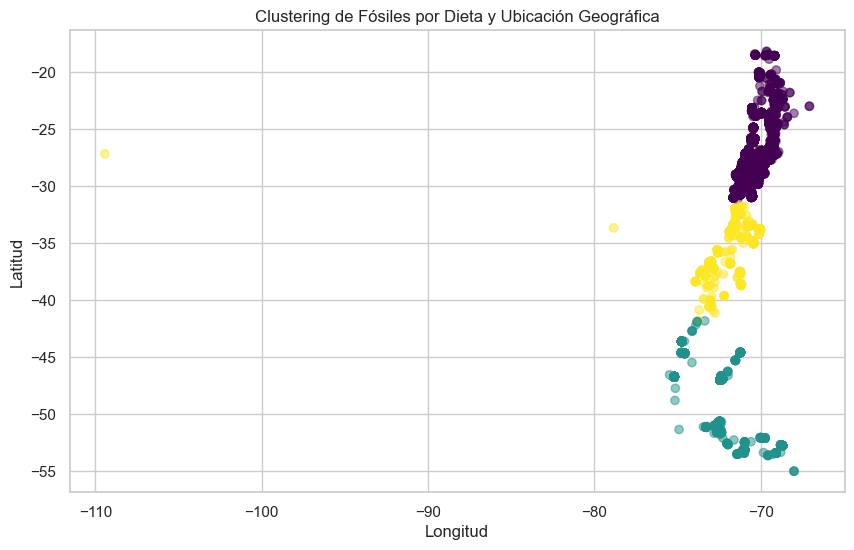

In [26]:
label_encoder = LabelEncoder()
chile_geo_df['diet_encoded'] = label_encoder.fit_transform(chile_geo_df['diet_grouped'])

X = chile_geo_df[['lat', 'lng', 'diet_encoded']]

kmeans = KMeans(n_clusters=3, random_state=0)  # 3 clusters es lo optimo
chile_geo_df['diet_cluster'] = kmeans.fit_predict(X)

print(chile_geo_df[['lat', 'lng', 'diet_encoded', 'diet_cluster']].head())

plt.figure(figsize=(10, 6))
plt.scatter(chile_geo_df['lng'], chile_geo_df['lat'], c=chile_geo_df['diet_cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering de Fósiles por Dieta y Ubicación Geográfica')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


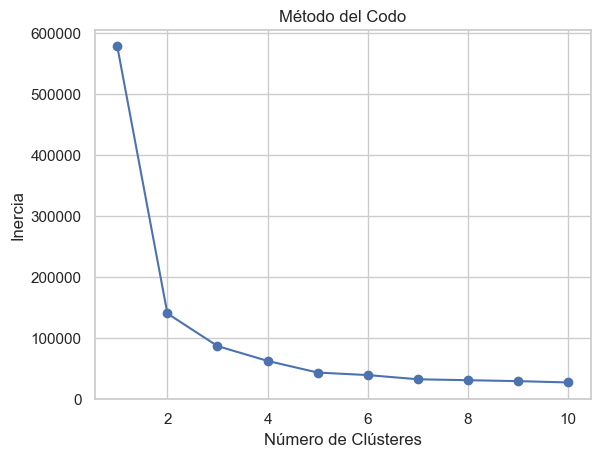

In [27]:
inertia = []
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()

Reduciendo los grupos:

Los consumidores secundarios pueden ser tanto carnívoros como omnívoros, dependiendo de su dieta y del ecosistema específico en el que se encuentren.

Carnívoros: Muchos consumidores secundarios son carnívoros, alimentándose de herbívoros (consumidores primarios). Estos organismos se sitúan en la parte superior de la cadena alimentaria.

Omnívoros: Algunos consumidores secundarios son omnívoros, lo que significa que consumen tanto materia vegetal (herbívoros) como animal (carnívoros). Esto les permite tener una mayor flexibilidad en su dieta y adaptarse a diferentes fuentes de alimento.

In [28]:
def categorize_diet(diet):
    if diet in ['filtros y suspensores', 'consumidores primarios']:
        return 'Herbívoro'
    elif diet in ['omnivoros']:
        return 'Omnívoro'
    else:
        return 'Carnívoro'

chile_geo_df['diet_category'] = chile_geo_df['diet_grouped'].apply(categorize_diet)


In [29]:
# Revisar la proporción de categorías de dieta por clúster
cluster_analysis = chile_geo_df.groupby('diet_cluster')['diet_category'].value_counts(normalize=True)
print(cluster_analysis)


diet_cluster  diet_category
0             Herbívoro        0.645097
              Carnívoro        0.331039
              Omnívoro         0.023864
1             Carnívoro        0.586836
              Herbívoro        0.299762
              Omnívoro         0.113402
2             Herbívoro        0.527426
              Carnívoro        0.455696
              Omnívoro         0.016878
Name: proportion, dtype: float64


Análisis por clúster:
Clúster 0:

Herbívoro: 64.51% (predomina).
Carnívoro: 33.10%.
Omnívoro: 2.39%.
Este clúster está dominado por fósiles de herbívoros, lo que sugiere un entorno favorable para estas especies, probablemente debido a la disponibilidad de recursos vegetales.

Clúster 1:

Carnívoro: 58.68% (predomina).
Herbívoro: 29.98%.
Omnívoro: 11.34%.
Este clúster está asociado principalmente con fósiles de carnívoros, aunque también incluye una proporción notable de herbívoros, lo que indica un ecosistema donde los depredadores tienen un papel significativo.

Clúster 2:

Herbívoro: 52.74% (predomina).
Carnívoro: 45.57%.
Omnívoro: 1.69%.
Este clúster está mayormente asociado con fósiles de herbívoros, aunque hay una proporción considerable de carnívoros. Esto sugiere que, aunque los herbívoros son predominantes, también hay una fuerte presencia de depredadores en el ecosistema.

Ahora continuamos con la graficacion correcta de los cluster.

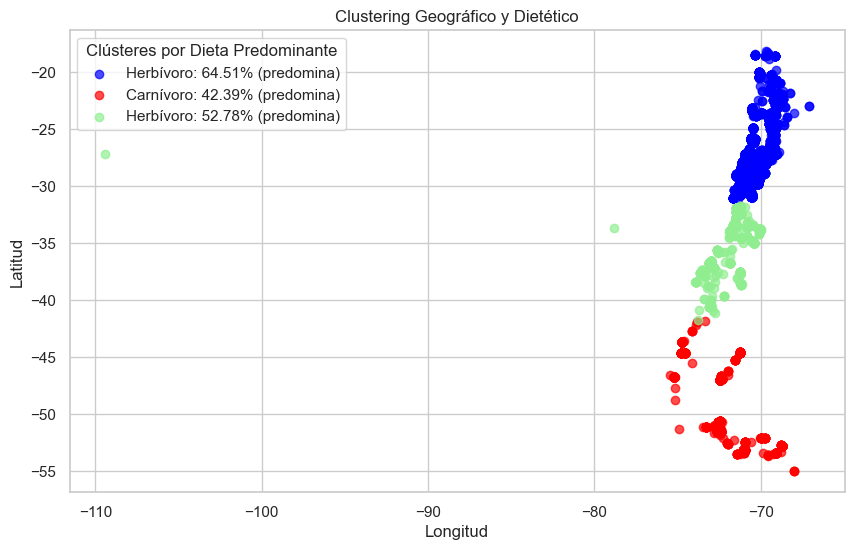

In [30]:
cluster_labels = {
    0: 'Herbívoro: 64.51% (predomina)',
    1: 'Carnívoro: 42.39% (predomina)', 
    2: 'Herbívoro: 52.78% (predomina)'
}
cluster_colors = {
    0: 'blue',  
    1: 'red',     
    2: 'lightgreen'  
}
plt.figure(figsize=(10, 6))
for cluster, label in cluster_labels.items():
    subset = chile_geo_df[chile_geo_df['diet_cluster'] == cluster]
    plt.scatter(
        subset['lng'], subset['lat'],
        c=cluster_colors[cluster], label=label,
        alpha=0.7
    )

plt.title('Clustering Geográfico y Dietético')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title="Clústeres por Dieta Predominante")
plt.show()

Clúster de fósiles herbívoros predominantes (64.51% de predominancia herbívora), distribuidos principalmente en la zona Norte de Chile.

Clúster de fósiles carnívoros predominantes (42.39% de predominancia omnívora), concentrados también en la zona centro-sur.

Clúster de fósiles herbívoros secundarios (52.78% de predominancia herbívora), localizados principalmente en el extremo centro del país.

En cuanto a la escasez de omnívoros observada en general, esto puede deberse a varios factores:

Especialización de nichos: Es posible que los ecosistemas fósiles documentados en Chile hayan estado más dominados por organismos con dietas más especializadas, ya sea herbívoros o carnívoros, dejando menos espacio para especies omnívoras generalistas.

Limitaciones en los registros fósiles: Los restos fósiles preservados pueden no representar plenamente la diversidad original de las comunidades, sesgando la representación de tipos de dieta más raros o menos preservados.

Condiciones ambientales específicas: Las características climáticas, geográficas y de disponibilidad de recursos en las diferentes regiones de Chile quizás hayan favorecido más a los herbívoros y carnívoros, dejando un papel menos prominente a los omnívoros.

Limitaciones en la reagrupación de las dietas: La forma en que se han clasificado y agrupado los tipos de dieta puede estar restringiendo la identificación de organismos con dietas más diversas o intermedias, como los omnívoros, en comparación con las categorías más polarizadas de herbívoros y carnívoros